# External variable - Bloch example

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vel_1000, int_1000 = nx.data.Load("spectrum_1000K.txt", x_index = 0, intensity_index = 1)
vel_800, int_800 = nx.data.Load("spectrum_800K.txt", x_index = 0, intensity_index = 1)
vel_600, int_600 = nx.data.Load("spectrum_600K.txt", x_index = 0, intensity_index = 1)
vel_400, int_400 = nx.data.Load("spectrum_400K.txt", x_index = 0, intensity_index = 1)
vel_200, int_200 = nx.data.Load("spectrum_200K.txt", x_index = 0, intensity_index = 1)

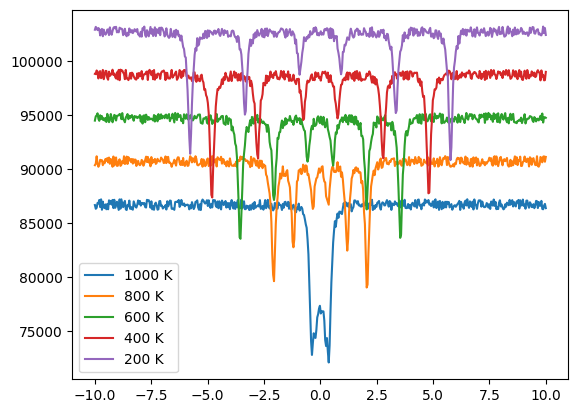

In [3]:
plt.plot(vel_1000, int_1000, label = "1000 K")
plt.plot(vel_800, int_800 + 4e3, label = "800 K")
plt.plot(vel_600, int_600 + 8e3, label = "600 K")
plt.plot(vel_400, int_400 + 12e3, label = "400 K")
plt.plot(vel_200, int_200 + 16e3, label = "200 K")
plt.legend()
plt.show()

In [4]:
# create external fit parameters
Tc = nx.Var(1040, min = 1000, max= 1100, fit = True, id = "Tc")
M_0 = nx.Var(40, min = 30, max= 50, fit = True, id ="M_0")
exponent = nx.Var(1.2, min = 1, max= 2, fit = True,id = "exponent")

# create a Bloch model function
# M(T) = M(0)* (1-(T/Tc)^3/2)
# we want to be able to fit all parameters
# Only the temperature T is known from the experiment
def Bloch(T):
    # return a magnetic field value in Tesla
    return M_0.value * (1 - (T/Tc.value)**(exponent.value))

#check the function call
print(Bloch(100))

37.59220236152488


In [5]:
# create the experiment in a for loop
# we assume that the oterh hyperfine parameters do not change individually
# we also want to fit the isomer shift as a common variable to all measurements
isomer_shift = nx.Var(0.5, min = -1, max = 1, fit = True, id = "isomer all")

# It is also possible to create additional Vars
# either in the function to be fit individually

# we can use the same beam object in each experient
beam = nx.Beam()
beam.Unpolarized()

# because the hyperfine parameters change we have to create new samples for each temperature
# also we have to pass the parameters of the experiment T and velocity and intensity data
def setup_specturm(temperature, velocity_data, intensity_data):
    site = nx.Hyperfine(weight=1,
                        isomer = isomer_shift,
                        # now assign the external function to the magnetic field of each experiment
                        # given by the Bloch function and the set temperature
                        magnetic_field = nx.Var(0, id="mag_at_"+str(temperature), equality = lambda: Bloch(temperature)),
                        isotropic = True)

    mat_Fe = nx.Material.Template(nx.lib.material.Fe)

    mat_Fe.hyperfine_sites = [site]

    layer_Fe = nx.Layer(id = "Fe",
                        material = mat_Fe,
                        thickness = 3000)

    sample = nx.Sample(layers = [layer_Fe])

    exp = nx.Experiment(beam = beam,
                        objects = [sample],
                        isotope = nx.lib.moessbauer.Fe57)

    spectrum = nx.MoessbauerSpectrum(experiment = exp,
                                     velocity = velocity_data,
                                     intensity_data = intensity_data)

    return spectrum

In [6]:
# create list to loop over
temps = [200, 400, 600, 800, 1000]
vels = [vel_200, vel_400, vel_600, vel_800, vel_1000]
dats = [int_200, int_400, int_600, int_800, int_1000]
measurements = []

# create all spectra
for t, v, d in zip(temps, vels, dats):
    measurements.append(setup_specturm(t,v,d))

In [7]:
fit = nx.Fit(measurements = measurements,
             id = "Bloch fit",
             external_fit_variables = [Tc, M_0, exponent])

In [8]:
fit()


Run Fit instance with id: Bloch fit 

Starting fit with 5 measurement data set(s) and 14 fit parameter(s):

  no. |                           id |       initial value |              min |              max
    0 |                   ES scaling |               87188 |                0 |       8.7188e+06
    1 |                    ES backgr |             8601.76 |                0 |           860176
    2 |                   isomer all |                 0.5 |               -1 |                1
    3 |                   ES scaling |               87193 |                0 |       8.7193e+06
    4 |                    ES backgr |             8603.46 |                0 |           860346
    5 |                   ES scaling |               87191 |                0 |       8.7191e+06
    6 |                    ES backgr |             8603.12 |                0 |           860312
    7 |                   ES scaling |               87188 |                0 |       8.7188e+06
    8 |           

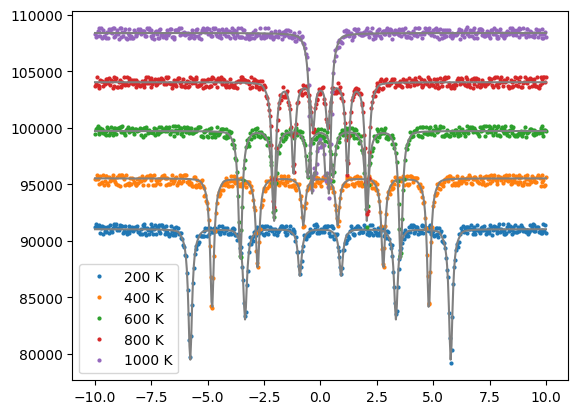

In [9]:
offset = 0
for t, v, d, m in zip(temps, vels, dats, measurements):
    int = m.Calculate()
    offset += max(int) * 0.05
    plt.plot(v, d + offset, label = str(t)+" K", marker='o', markersize = 2, linewidth=0)
    plt.plot(v, int + offset, color='grey')

plt.legend()
plt.show()